# New York City: Parking Tickets Analysis
![New York City](https://blog-www.pods.com/wp-content/uploads/2019/04/MG_1_1_New_York_City-1.jpg)

In this notebook, we shall be analysing the data that NYC Department of Finance collects on every **parking ticket** issued in the city to deliver insights to the governing body (let's just imagine one 😋)

You can find more details about the dataset [**here**](https://www.kaggle.com/new-york-city/nyc-parking-tickets)

The notebook consists of four parts - **Environment Setup**, **Reading Data**, **Cleaning** & **Analysis**

We shall be using the first **5 Million** rows from the original dataset for our analysis

*So let's get started!*

## I. Environment Setup

In [3]:
# Import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

start_time = time.time()

## II. Reading Data

In [4]:
# Create Pandas dataframe with only 5 Million rows
# Change from original: We create two versions of this data: one with 5 million rows, and another with 5 million rows duplicated to 11g. Using the entire dataset causes a parse error.
nyc_parking_tickets = pd.read_csv("input/nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2016.csv")

In [5]:
# View top 5 rows
nyc_parking_tickets.head(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
2,4006265037,FZX9232,NY,PAS,08/23/2016,5,SUBN,FORD,V,0,...,BK,NaN,2004,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN
3,8478629828,66623ME,NY,COM,06/14/2017,47,REFG,MITSU,T,10610,...,WH,NaN,2007,NaN,0,04,47-Double PKG-Midtown,NaN,NaN,NaN
4,7868300310,37033JV,NY,COM,11/21/2016,69,DELV,INTER,T,10510,...,WHITE,NaN,2007,NaN,0,31 6,69-Failure to Disp Muni Recpt,NaN,NaN,NaN


In [6]:
# View shape of dataframe (rows,columns)
nyc_parking_tickets.shape

(5000000, 43)

## III. Cleaning

In [7]:
# Change column names
nyc_parking_tickets.columns = ['SummonsNumber', 'PlateID', 'RegistrationState', 'PlateType', 'IssueDate', 'ViolationCode', 'VehicleBodyType', 'VehicleMake', 'IssuingAgency', 'StreetCode1', 'StreetCode2', 'StreetCode3','VehicleExpirationDate', 'ViolationLocation', 'ViolationPrecinct','IssuerPrecinct', 'IssuerCode', 'IssuerCommand', 'IssuerSquad', 'ViolationTime', 'TimeFirstObserved', 'ViolationCounty', 'ViolationInFrontOfOrOpposite', 'HouseNumber', 'StreetName', 'IntersectingStreet', 'DateFirstObserved', 'LawSection', 'SubDivision', 'ViolationLegalCode', 'DaysParkingInEffect', 'FromHoursInEffect', 'ToHoursInEffect', 'VehicleColor', 'UnregisteredVehicle', 'VehicleYear', 'MeterNumber', 'FeetFromCurb', 'ViolationPostCode', 'ViolationDescription', 'NoStandingOrStoppingViolation', 'HydrantViolation', 'DoubleParkingViolation']

# Drop columns with > 80% null values
columns_to_drop = ((nyc_parking_tickets.isna().sum()/len(nyc_parking_tickets))*100) > 80
nyc_parking_tickets.drop(columns_to_drop[columns_to_drop.values == True].index.tolist(),axis=1,inplace=True)

# Convert 'IssueDate' to datetime  -rem
nyc_parking_tickets['IssueDate'] = pd.to_datetime(nyc_parking_tickets['IssueDate'],format='%m/%d/%Y',errors='coerce')

# Replace '99' in RegistrationState column by null
nyc_parking_tickets['RegistrationState'] = nyc_parking_tickets['RegistrationState'].replace({'99': None})

# Replace '999' in PlateType column by null
nyc_parking_tickets['PlateType'] = nyc_parking_tickets['PlateType'].replace({'999': None})

# Convert incorrent values (88888888, etc.) in 'VehicleExpirationDate' column to Null
incorrect_values = nyc_parking_tickets[(nyc_parking_tickets['VehicleExpirationDate'] > 20990101)]['VehicleExpirationDate'].unique().tolist()
nyc_parking_tickets[nyc_parking_tickets['VehicleExpirationDate'].isin(incorrect_values)] = None

# Convert 'ViolationTime' column to stirng and convert values not containing 'A/P' (ambiguous) to null
nyc_parking_tickets['ViolationTime'] = nyc_parking_tickets['ViolationTime'].astype('str')
ViolationTime_ambiguous = nyc_parking_tickets[~nyc_parking_tickets['ViolationTime'].str.contains('P|A')]['ViolationTime'].unique().tolist()
nyc_parking_tickets[nyc_parking_tickets['ViolationTime'].isin(ViolationTime_ambiguous)] = None

# Fix 'DateFirstObserved' column
    # Replace NaN values with 0
    # Replace 0 with null
    # Convert the column to datetime
nyc_parking_tickets['DateFirstObserved'] = nyc_parking_tickets['DateFirstObserved'].replace({np.NaN:0}).astype('int') 
nyc_parking_tickets['DateFirstObserved'] = nyc_parking_tickets['DateFirstObserved'].replace({0:None})
nyc_parking_tickets['DateFirstObserved'] = pd.to_datetime(nyc_parking_tickets['DateFirstObserved'],format='%Y%m%d',errors='coerce')

# Drop duplicates based on 'SummonsNumber' column as summon numbers should be unique
nyc_parking_tickets.drop_duplicates(subset = ['SummonsNumber'], inplace = True)

## IV. Analysis

<AxesSubplot:xlabel='IssuingAgency', ylabel='SummonsNumber'>

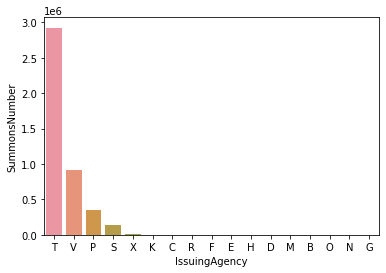

In [8]:
# Issuing agency vs Summons dataframe
ia_plot = nyc_parking_tickets.groupby(['IssuingAgency']).count()['SummonsNumber'].sort_values(ascending=False).reset_index()
# Bar plot
sns.barplot(x = 'IssuingAgency', y = 'SummonsNumber', data = ia_plot)

Agency with code **T** was issued the maximum number of summons

In [9]:
# Vehicle registration state (Top 10) vs Summons
nyc_parking_tickets.groupby(['RegistrationState']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,RegistrationState,SummonsNumber
0,NY,3669085
1,NJ,141036
2,PA,122196
3,FL,64374
4,CT,39228
5,MA,35082
6,VA,32057
7,MD,25059
8,NC,24019
9,IN,18740


The vehicle registration state with the highest number of summons was **New York**

In [10]:
# Plate Type (Top 10) vs Summons
nyc_parking_tickets.groupby(['PlateType']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,PlateType,SummonsNumber
0,PAS,3282061
1,COM,638695
2,OMT,205471
3,OMS,50184
4,SRF,40520
5,IRP,26160
6,TRC,12562
7,MOT,11384
8,OMR,9372
9,ORG,8275


The vehicle plate type with the highest number of summons was **PAS**

In [11]:
# Plate ID (Top 5) vs Summons
nyc_parking_tickets.groupby(['PlateID']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(5)

,PlateID,SummonsNumber
0,BLANKPLATE,4087
1,47603MD,422
2,16242TC,370
3,16213TC,359
4,47832MD,350


Amongst the different registered vehicle plate IDs, the maximum number of tickets were issued to **no-plate-id (blank plates)**

(array([16983., 17045., 17106., 17167., 17226., 17287., 17348.]),
 [Text(16983.0, 0, '2016-07'),
  Text(17045.0, 0, '2016-09'),
  Text(17106.0, 0, '2016-11'),
  Text(17167.0, 0, '2017-01'),
  Text(17226.0, 0, '2017-03'),
  Text(17287.0, 0, '2017-05'),
  Text(17348.0, 0, '2017-07')])

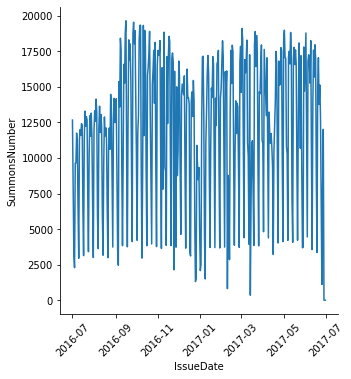

In [12]:
# Issue date time series plot
issue_date = nyc_parking_tickets.loc[:,['IssueDate','SummonsNumber']].groupby('IssueDate').count()['SummonsNumber'].reset_index()
sns.relplot(x = 'IssueDate', y = 'SummonsNumber', data = issue_date, kind = "line")
plt.xticks(rotation = 45)

From the above time series plot, we can observe that the peak of issuing tickets occured between the **September to November 2016** peiod (Time duration - July, 2016 to July, 2017) 

<AxesSubplot:xlabel='SummonsNumber', ylabel='ViolationDescription'>

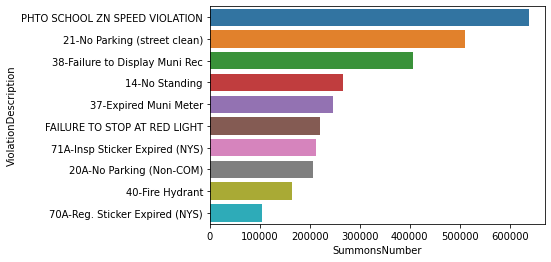

In [13]:
# Top 10 Violations dataframe
top_10_violations = nyc_parking_tickets.loc[:,['ViolationDescription','SummonsNumber']].groupby(['ViolationDescription']).count()['SummonsNumber'].reset_index().sort_values('SummonsNumber',ascending = False).head(10)
# Bar plot
sns.barplot(x = 'SummonsNumber', y = 'ViolationDescription', data = top_10_violations)

The maximum number of tickets were issued for **overspeeding near school premises** violation

In [14]:
# Violation Time (Top 10) vs Summons
nyc_parking_tickets.groupby(['ViolationTime']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,ViolationTime,SummonsNumber
0,0836A,11978
1,1140A,11347
2,1136A,11327
3,0840A,10639
4,0940A,10397
5,0906A,10396
6,0936A,10298
7,1145A,10150
8,0845A,10030
9,0945A,9938


From the above table, it is quite evident that the maximum number of violations occured **between 8 AM to 12 PM**

<AxesSubplot:xlabel='ViolationCounty', ylabel='SummonsNumber'>

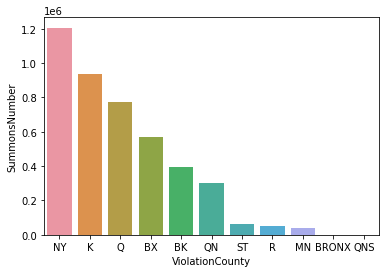

In [15]:
# Vehicle County vs Summons
vc_plot = nyc_parking_tickets.groupby(['ViolationCounty']).count()['SummonsNumber'].sort_values(ascending=False).reset_index()
# Bar plot
sns.barplot(x = 'ViolationCounty', y = 'SummonsNumber', data = vc_plot)

The maximum number of violations occured in the county of **New York**

In [16]:
# Vehicle Body Type (Top 10) vs Summons
nyc_parking_tickets.groupby(['VehicleBodyType']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,VehicleBodyType,SummonsNumber
0,SUBN,1601894
1,4DSD,1300941
2,VAN,462557
3,SDN,196519
4,DELV,192864
5,2DSD,114129
6,PICK,107476
7,REFG,36517
8,TAXI,27902
9,4 DR,24211


**SUBN** vehicle body type accounted for the maximum number of violations 

In [17]:
# Vehicle Make (Top 10) vs Summons
nyc_parking_tickets.groupby(['VehicleMake']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,VehicleMake,SummonsNumber
0,TOYOT,524916
1,FORD,524482
2,HONDA,464261
3,NISSA,398798
4,CHEVR,275891
5,ME/BE,163022
6,BMW,157577
7,JEEP,148070
8,DODGE,147643
9,HYUND,128261


The highest number of tickets were issued to **Toyota** vehicles

In [18]:
# Vehicle Make + Body Type (Top 5) vs Summons
nyc_parking_tickets.groupby(['VehicleMake','VehicleBodyType']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(5)

,VehicleMake,VehicleBodyType,SummonsNumber
0,TOYOT,4DSD,233754
1,FORD,VAN,214737
2,TOYOT,SUBN,199792
3,HONDA,SUBN,194287
4,HONDA,4DSD,192598


**Toyota** vehicles of body type **4DSD** accounted for the maximum number of summons

In [19]:
# Vehicle Location vs Summons
nyc_parking_tickets.groupby(['ViolationLocation']).count()['SummonsNumber'].sort_values(ascending=False).reset_index().head(10)

,ViolationLocation,SummonsNumber
0,19.0,191666
1,114.0,124203
2,1.0,116203
3,14.0,112670
4,18.0,101835
5,109.0,89433
6,70.0,82233
7,13.0,81836
8,115.0,72171
9,61.0,71081


The general violation location number **19** was issued the maximum number of tickets

In [20]:
# Registration State, Violation Description & Summons Number
nyc_parking_tickets.loc[:,['RegistrationState','ViolationDescription','SummonsNumber']].groupby(['RegistrationState','ViolationDescription']).count()['SummonsNumber'].reset_index().sort_values('SummonsNumber',ascending = False).head(5)

,RegistrationState,ViolationDescription,SummonsNumber
1767,NY,PHTO SCHOOL ZN SPEED VIOLATION,547492
1683,NY,21-No Parking (street clean),424087
1699,NY,38-Failure to Display Muni Rec,356195
1698,NY,37-Expired Muni Meter,224157
1675,NY,14-No Standing,214231


The maximum number of tickets were issued for **overspeeding near school premises** violation with vehicles registered in NY 

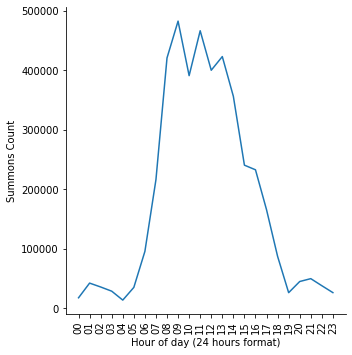

In [21]:
# Time series plot (ViolationTime vs Summons)

# Concatenate 'M' to 'ViolationTime' column 
nyc_parking_tickets['ViolationTime'] = nyc_parking_tickets['ViolationTime'] + 'M'
# Convert the column to datetime
nyc_parking_tickets['ViolationTime'] = pd.to_datetime(nyc_parking_tickets['ViolationTime'],format='%I%M%p',errors='coerce')
# Extract hour from the 'ViolationTime' column 
nyc_parking_tickets['ViolationTime'] = nyc_parking_tickets['ViolationTime'].dt.strftime('%H')
# Prepare dataframe for time series plot
time_series_summons = nyc_parking_tickets.groupby(['ViolationTime']).count()['SummonsNumber'].reset_index().sort_values(['ViolationTime'])

# Time series plot using seaborn
sns.relplot(x = "ViolationTime", y = "SummonsNumber", data = time_series_summons, kind = "line", ci = None)
plt.xlabel("Hour of day (24 hours format)")
plt.xticks(rotation = 90)
plt.ylabel("Summons Count")
plt.show()

From the above line plot, we can see that the peak for the maximum number of summons in a day occured around **9 AM**

![](https://i.ytimg.com/vi/0QI4eG8D0Ic/maxresdefault.jpg)

This brings us to the end of the notebook

In this Kaggle notebook, we read 5 Million rows from the NYC Parking dataset, performed data wrangling and later analysed to deliver insights

Since I'm a beginner, I would love to have your valuable feedback and suggestions so that I can keep on improving

Also, if you liked my work, please consider upvoting this notebook, would mean a lot to me!

Thank you😄

In [22]:
end_time = time.time()
print(f"Total time: {end_time - start_time} s")

Total time: 229.5299859046936 s
